In [1]:
import sys 
import pytorch_lightning as pl
import seml
import torch
from sacred import SETTINGS, Experiment
import pandas as pd
import scanpy as sc

sys.path.insert(0,"../")
from paths import EXPERIMENT_FOLDER

from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.models.base.vae import VAE, AE
from scCFM.models.base.geometric_vae import GeometricNBVAE

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger

torch.set_printoptions(precision=5)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [24]:
training = {"task_name": "sweep_try_geom_vae",
              "seed": 42}

data ={"path": "/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad",
                "x_layer": "X_norm",
                "cond_key": "experimental_time",
                "use_pca": False,
                "n_dimensions": None,
                "train_val_test_split": [0.80, 0.2],
                "batch_size": 512,
                "num_workers": 2}

# Model
vae = {'n_epochs_anneal_kl': 500, 
       'kl_weight': 0.01, 
       'likelihood': 'nb',
       'dropout': False, 
       'dropout_p': False, 
       'model_library_size': False, 
       'batch_norm': True, 
       'kl_warmup_fraction': 1, 
       'learning_rate': 0.001, 
       'hidden_dims': [512, 256, 10]}


# Geometric VAE version
geometric_vae = {'compute_metrics_every': 1,
               'use_c': False,
               'l2': True,
               'fl_weight': 100,
               'eta_interp': 0.2,
               'interpolate_z': False, 
               'start_jac_after': 5,
               'detach_theta': True}

  # Callbacks 
model_checkpoints = {"filename": "epoch_{epoch:04d}",
                    "monitor": "val/loss",
                    "mode": "min",
                    "save_last": False,
                    "auto_insert_metric_name": False}

early_stopping = {"perform_early_stopping": False,
                      "monitor": "val/loss",
                      "patience": 50,
                      "mode": "min",
                      "min_delta": 0.,
                      "verbose": False,
                      "strict": True,
                      "check_finite": True, 
                      "stopping_threshold": None,
                      "divergence_threshold": None, 
                      "check_on_train_epoch_end": None}

logger = {"offline": False,
         "id": None ,
         "project": "sweep_try_geom_vae",
         "log_model": True,
         "prefix": "",
         "group": "",
         "tags": [],
         'job_type': ""}


  # Trainer
trainer = {"max_epochs": 500,
            "accelerator": "gpu",
            "devices": 1,
            "log_every_n_steps": 10}

In [25]:
task_name = training["task_name"] 

# Fix seed for reproducibility
torch.manual_seed(training["seed"])      
if training["seed"]: 
    pl.seed_everything(training["seed"], workers=True)

# Initialize folder 
current_experiment_dir = EXPERIMENT_FOLDER / task_name
current_experiment_dir.mkdir(parents=True, exist_ok=True) 

# Initialize datamodule
datamodule = scDataModule(**data)

vae["in_dim"] = datamodule.in_dim
model = GeometricNBVAE(**geometric_vae,
                            vae_kwargs=vae)
# model = VAE(**vae)
        
# Initialize callbacks 
model_ckpt_callbacks = ModelCheckpoint(dirpath=current_experiment_dir / "checkpoints", 
                                            **model_checkpoints)
        
# Initialize callbacks 
if early_stopping["perform_early_stopping"]:
    early_stopping_callbacks = EarlyStopping(**early_stopping)
else:
    early_stopping_callbacks = None
             

# Initialize logger 
logger = WandbLogger(save_dir=current_experiment_dir, 
                          **logger) 
        

if early_stopping_callbacks != None:
    callbacks = [model_ckpt_callbacks, early_stopping_callbacks]
else:
    callbacks = model_ckpt_callbacks
# Initialize the lightning trainer 
trainer = Trainer(callbacks=callbacks, 
                  default_root_dir=current_experiment_dir,
                  gradient_clip_val=1,
                  **trainer)

[rank: 0] Global seed set to 42
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-pa ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Fit the model 
trainer.fit(model=model, 
                  train_dataloaders=datamodule.train_dataloader(),
                  val_dataloaders=datamodule.val_dataloader())

train_metrics = trainer.callback_metrics

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /nfs/students/pala/scCFM/experiments/sweep_try_geom_vae/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type   | Params
------------------------------------------
0 | encoder_layers | MLP    | 768 K 
1 | decoder_layers | MLP    | 135 K 
2 | decoder_mu_lib | Linear | 636 K 
3 | mu_logvar      | Linear | 5.1 K 
------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.191     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [50]:
ls

examine_ae.ipynb             examine_vae.ipynb  save_anndata.ipynb
examine_ae_lib.ipynb         models_ae/
examine_vae_geometric.ipynb  models_vae/


In [70]:
model.load_state_dict(torch.load("/nfs/homedirs/pala/scCFM/notebooks/pullback_geometry/models/model_fl_1000_annealing_kl.ckpt")["state_dict"])

<All keys matched successfully>

**further checks**

In [71]:
torch.exp(model.theta).mean()

tensor(1.64730, device='cuda:0', grad_fn=<MeanBackward0>)

In [72]:
torch.exp(model.theta).max()

tensor(21.77691, device='cuda:0', grad_fn=<MaxBackward1>)

In [73]:
torch.exp(model.theta).min()

tensor(0.03909, device='cuda:0', grad_fn=<MinBackward1>)

In [74]:
torch.exp(model.theta)

tensor([1.37784, 0.32717, 0.32914,  ..., 0.25832, 0.60827, 0.68564],
       device='cuda:0', grad_fn=<ExpBackward0>)

In [75]:
batch = next(iter(datamodule.train_dataloader()))
batch["X"] = batch["X"].cuda()

In [76]:
z, mu, logvar = model.cuda().encode(batch["X"]).values()

In [77]:
res = model._preprocess_decoder_output(model.decode(z))

In [78]:
res["mu"].max(1)

torch.return_types.max(
values=tensor([ 33.86330,  22.73917,  21.83586,  20.68721,  33.86719,  21.45018,
         21.54520,  32.97278,  25.74155,  24.40862,  21.09184,  26.60003,
         27.33200,  37.64785,  63.41861,  30.98363,  39.01332,  16.74510,
         26.79486,  20.38252,  17.85719,  37.86238,  29.99430,  35.83360,
         27.72357,  18.40059,  33.59943,  21.18881,  18.40530,  23.99183,
         27.91814,  29.66156,  43.09864,  35.20066,  19.78828,  25.89128,
         22.43545,  34.99061,  26.61430,  20.96296,  33.46421,  36.43247,
         26.75825,  19.93464,  26.23170,  22.83452,  26.38753,  19.01994,
         31.18337,  21.28078,  26.44611,  23.43128,  49.56908, 106.19688,
         23.20353,  21.24384,  38.78787,  23.00535,  21.74254,  29.81330,
         22.56159,  29.03802,  20.63797,  26.00426,  25.11443,  39.01278,
         20.64575,  28.00577,  35.70533,  24.70510,  22.37895,  20.77818,
         20.18046,  16.05224,  28.11855,  24.03185,  34.70693,  22.06962,
       

In [79]:
batch["X"].max(1)

torch.return_types.max(
values=tensor([ 26.12448,  24.59770,  39.14119,  23.36065,  28.11742,  26.88629,
         29.06881,  28.72030,  32.25398,  22.90728,  35.77930,  35.12239,
         31.70246,  55.60574,  67.34118,  22.72469,  30.87322,  23.98839,
         31.54490,  30.09425,  19.51062,  96.98221,  30.56048,  29.94205,
         42.88382,  21.18642,  35.38833,  33.71003,  29.33558,  20.12055,
         21.41542,  23.93438,  63.65762,  36.26315,  27.60601,  34.75166,
         27.14714,  30.53523,  22.92845,  28.97481,  67.54901,  33.50885,
         29.80599,  22.76696,  24.37375,  38.36810,  35.12320,  41.28546,
         31.13758,  21.10530,  34.23265,  30.65686,  72.68245, 100.82928,
         25.07142,  21.00901,  40.54414,  37.40720,  25.38206,  21.46736,
         25.41119,  30.96630,  27.06915,  31.39747,  30.36661,  32.40043,
         26.36997,  31.31334,  37.27287,  22.19468,  35.23868,  27.90101,
         28.21201,  27.08117,  49.65473,  20.64523,  42.74650,  37.06113,
       

In [80]:
I = model.theta.unsqueeze(0) * \
                1 / (res["mu"] * (model.theta.unsqueeze(0) + res["mu"]))

In [81]:
I

tensor([[104.27374,  37.90121,  42.28893,  ...,  50.47263,   8.22918,
          43.34253],
        [ 90.94843,  39.74929,   9.69789,  ...,  37.99525,  -0.74165,
          61.91431],
        [ 49.04111,  30.63652,  11.03244,  ...,  24.37561,  -0.16344,
         105.91778],
        ...,
        [ 70.91992,  20.70672,  17.15761,  ...,  16.71110,  -0.15408,
          81.21387],
        [ 69.87479,  29.64057,  16.68558,  ...,  30.06141,  -1.87825,
          44.51479],
        [115.22713,  45.21473,  24.19178,  ...,  60.16335, -35.01909,
          59.67668]], device='cuda:0', grad_fn=<DivBackward0>)

In [82]:
res["mu"][0]

tensor([0.00932, 0.02704, 0.02417,  ..., 0.02011, 0.21150, 0.02469],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [83]:
model.metric(z, res)[0]

tensor([[ 493.21930, -215.97151,  -79.98879, -262.80179,  243.93793,  -19.35193,
          -41.53876,   34.66198,   -6.82012, -145.34663],
        [-215.97153,  489.64569,  -45.01432,   62.04535, -270.31979,   78.13451,
          -13.80195, -146.31384,   81.52974,  -19.93369],
        [ -79.98879,  -45.01433,  771.26428,   -4.78898,   32.36569, -232.80687,
         -267.52383,   36.80557, -266.50348,   56.19088],
        [-262.80179,   62.04535,   -4.78897,  679.92694, -535.07947,  193.22592,
          -68.49173, -220.53539,   -7.51845,  164.01805],
        [ 243.93796, -270.31979,   32.36568, -535.07959, 1029.55408, -322.26117,
          -58.41447,  255.18375, -160.79535, -214.17178],
        [ -19.35193,   78.13451, -232.80688,  193.22592, -322.26120,  451.01324,
           87.67406, -164.79875,  -61.67468,   -9.15420],
        [ -41.53876,  -13.80195, -267.52386,  -68.49174,  -58.41446,   87.67406,
          459.47446,  -60.60073,   45.68597,  -82.46303],
        [  34.66198, -146.3

**Get umap**

In [84]:
cells = []
annot = []

with torch.no_grad():
    for batch in datamodule.train_dataloader():
        batch["X"] = batch["X"].cuda()
        z, mu, logvar = model.cuda().encode(batch["X"]).values()
        annot.append(batch["cond"])
        cells.append(z)
    
cells = torch.cat(cells, dim=0)
annot = torch.cat(annot).numpy()
annot = pd.DataFrame(annot)
annot.columns = ["experimental_time"]

In [85]:
adata = sc.AnnData(X=cells.cpu().numpy(), 
                  obs=annot)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [86]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

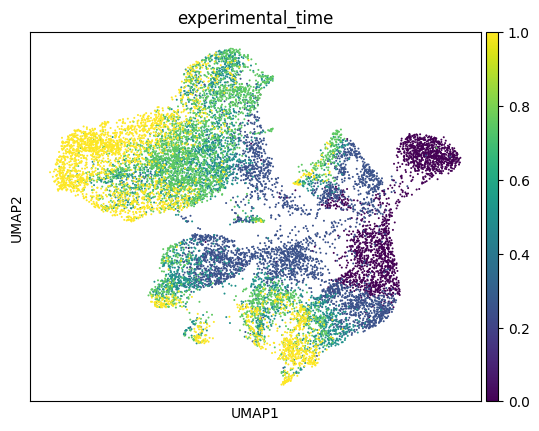

In [87]:
sc.pl.umap(adata, color="experimental_time")

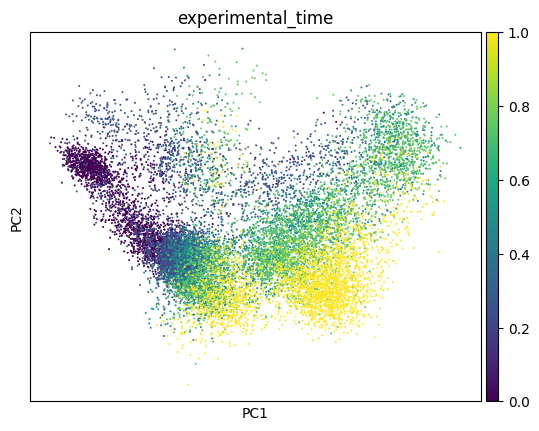

In [88]:
sc.pl.pca(adata, color="experimental_time")

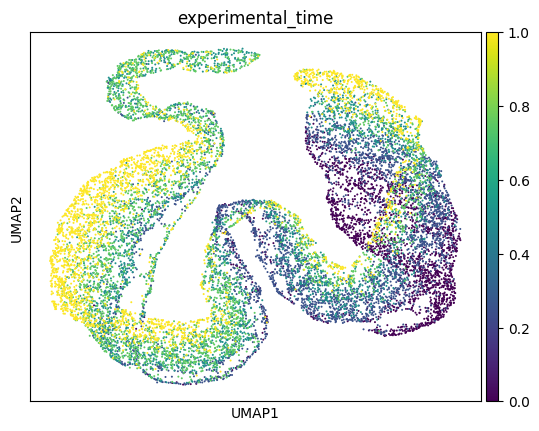

In [46]:
sc.pl.umap(adata, color="experimental_time")

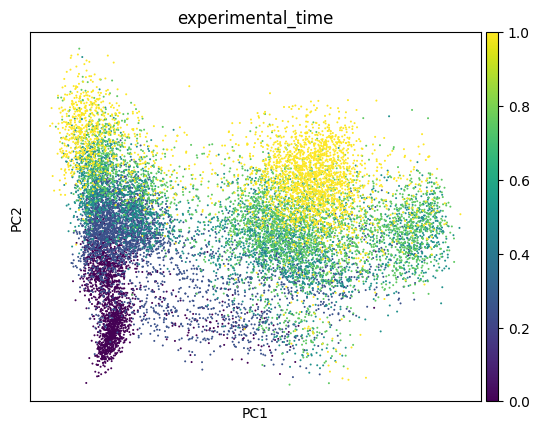

In [47]:
sc.pl.pca(adata, color="experimental_time")

* encode 8 gaussians 2 moons
* synthetic data where this lie on a sphere 
* project onto a sphere such that straightforward ot fails 